In [1]:
## Scikit learn libraries
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

## For NLP
from bs4 import BeautifulSoup, Tag    ## Cleaning HTML tags from text
import nltk, string
from nltk.corpus import stopwords 
import re

## Common Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data I/O
import json     ## To convert json raw data to df
import pickle   ## saving the model to disk

import xgboost as xgb
from scipy.stats import uniform, randint

#from keras.preprocessing import text, sequence
#from keras import layers, models, optimizers

## Problem texts can be long and may not load on Jupyter
pd.set_option('display.max_colwidth', -1)    

## Extract subject wise training data

In [2]:
# Load the dataset and show sample question
with open('../data/qs_topicwise.json') as json_data:
    all_questions = json.load(json_data)

subject_model = ['MTH']

## Create empty df 
data_df = pd.DataFrame(columns=['code', 'curriculum', 'subject', 'grade', 'question_text', 'chapter'])

## Removing these words improves Phy clf accuracy by 2% but improves Math classifier accuracy
words_to_remove = [ "a", "an", "the"]
stop_words = stopwords.words('english')         ## Downloaded from NLTK
'''
for PHY - removing Stopwords reduce acc & f1 score : 67% -> 63%, 74% -> 72%
for CHM - removing Stopwords reduce acc & f1 score by 6%
for MTH - removing stopwords reduce acc & f1 score by 7%
'''

## Remove dummy and empty chapters
chapters_to_remove = ['Selection Test', 'Repository', 'Bridge Intervention Curriculum', 
                      'M1.1 Scaffold test', 'Tally Marks', 'Dummy']
chapters_with_no_data = ['Static Electricity', 'Experimental Skills', 'Nuclear Chemistry', 
                         'Principle of Mathematical Induction', 'Environmental Chemistry']

## Regex pattern for alpha numeric - Improves accuracy & f1-score for Phy by 2%
pattern = re.compile('[\W_]+')

i = 0
for question in all_questions:
    try: 
        question_text = question['question_text'].lower()
        ## Remove HTML tags from text using Beautiful Soup
        '''
        For MTH, it improves accuracy from 40% to 60% in MTH, 
        For PHY, it reduces accuracy from 60% to 20%. 
        For CHM, it increases accuracy from 50% to 52% 
        '''
        question_text = BeautifulSoup(question_text, "html.parser").get_text() 
        ## Remove numbers
        '''
        For PHY, removing nos improved accuracy & F1 score by 0.5%
        For CHM, removing nos improved acc by 2%
        '''
        question_text = ''.join(c for c in question_text if not c.isdigit())
        ## Regex pattern for alpha numeric text
        '''
        For CHM, replacing this regex pattern by space improved score by 9%
        For MTH, replacing this regex pattern by space improved score by 15%
        '''
        question_text = pattern.sub(" ", question_text)
        ## Remove stop words
        '''
        For CHM, keeping both sets of words, instead of removing them improved acc by 5%
        For MTH, keeping both sets of words, instead of removing them improved acc by 8%
        '''
        question_text = " ".join([word for word in question_text.split() if word not in words_to_remove])
        #question_text = " ".join([word for word in question_text.split() if word not in stop_words])
        ## Remove extra whitespaces
        question_text = " ".join(question_text.split()) 
        ## Extracting elements for cleaner code
        grade = question['grade']
        curriculum = question['curriculum']
        chapter = question['chapter']
        subject = question['subject']
        ## Filtering each question from JSON to add relevant Qs to dataframe 
        if(    "JEE" in curriculum and grade in ["11", "12"] and
               chapter not in chapters_to_remove and
               chapter not in chapters_with_no_data and
               "dummy" not in question_text and subject in subject_model):
                data_df.loc[i] = [question['problem_code'], curriculum, subject, \
                                  grade, question_text, chapter]
                i += 1
    except:
            pass

trainDF = pd.DataFrame(columns=['text', 'label'])
trainDF['text'] = data_df['question_text']
trainDF['label'] = data_df['chapter']
trainDF.head(3)

,text,label
0,among statements given below which one is correct,Inverse Trigonometry
1,sin left frac right,Inverse Trigonometry
2,principal domain of cos 𝑥 is,Inverse Trigonometry


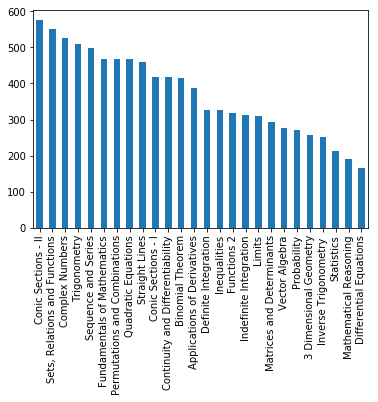

In [3]:
trainDF.label.value_counts().plot(kind="bar")

## Train test split

In [4]:
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(trainDF['text'], trainDF['label'], test_size=0.2)
print(len(train_x), len(valid_x) )

7741 1936


## Create pipeline for vectorizer & classifier

Label encoding is not needed. All sklearn classifiers are capable of mutli-class classification. Source :  https://stackoverflow.com/questions/51525043/encoding-labels-for-multi-class-problems-in-sckit-learn

In [5]:
## Custom Tokenizer for Vectorizer (no default by sklearn)
'''
for PHY - improves accuracy & f1 score by 2%
for CHM - improves by 5%
for MTH - 
'''
stemmer = nltk.stem.porter.PorterStemmer()    ## May need to download this with "nltk.download('punkt')"
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)
def stem_tokens(tokens):
    return [stemmer.stem(item) for item in tokens]
def normalize(text):
    return stem_tokens(nltk.word_tokenize(text.translate(remove_punctuation_map)))

## Initializing vectorizer
vec = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3),
                      lowercase=True, tokenizer=normalize, max_features=10000, 
                      use_idf = True, min_df = 5, max_df = 0.8, stop_words = None)
## Can't add stop words here as the text is normalized and it won't match the stop words list. Should remove earlier.
## https://stackoverflow.com/questions/57340142/user-warning-your-stop-words-may-be-inconsistent-with-your-preprocessing

## Initializaing classifier
#clf = naive_bayes.MultinomialNB(alpha=0.3)                                          ## Accuracy 74% 
clf = linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg', C=7.5)   ## Accuracy 79%
#clf = xgb.XGBClassifier(objective="multi:softprob", random_state=42,                   ## Acc 75.6%
#                        learning_rate=0.3, n_estimators=150)                           
#clf = RandomForestClassifier(n_estimators=120, max_depth=20, min_samples_leaf=5,      ## Acc 44%
#                             max_features=0.6, n_jobs=-1, oob_score=True)      
#clf = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-4,                               ## Accuracy 78%
#                    random_state=42, max_iter=3, tol=None)
## Source : https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

## Setting up pipeline
pipe = make_pipeline(vec, clf)
pipe.fit(train_x, train_y)

Pipeline(memory=None,
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.8, max_features=10000, min_df=5,
        ngram_range=(2, 3), norm='l2', preprocessor=None, smoot...ty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False))])

## Prediction & Evaluation metrics

In [6]:
pred_y = pipe.predict(valid_x)
report = metrics.classification_report(valid_y, pred_y)
print(report)
print("accuracy: {:0.3f}".format(metrics.accuracy_score(valid_y, pred_y)))
print("F1-score (weighted): {:0.3f}".format(metrics.f1_score(valid_y, pred_y, average = 'weighted')))
## Support is the number of occurrences of each class in valid_y

                                  precision    recall  f1-score   support

          3 Dimensional Geometry       0.83      0.62      0.71        47
     Applications of Derivatives       0.56      0.51      0.53        73
                Binomial Theorem       0.85      0.79      0.82        90
                 Complex Numbers       0.88      0.83      0.85        95
              Conic Sections - I       0.86      0.88      0.87        96
             Conic Sections - II       0.91      0.82      0.86       122
Continuity and Differentiability       0.53      0.69      0.60        67
            Definite Integration       0.78      0.70      0.74        57
          Differential Equations       0.88      0.82      0.85        28
                     Functions 2       0.59      0.60      0.59        67
     Fundamentals of Mathematics       0.66      0.73      0.69       106
          Indefinite Integration       0.90      0.83      0.86        69
                    Inequalities     

This is a higher accuracy than the baseline Naive Bayes model made earlier !
It can be attributed to the Logistic Regression model, along with custom tokenizer better hyper parameters

### Confusion Matrix

In [7]:
metrics.confusion_matrix(valid_y, pred_y)

array([[ 29,   1,   0,   0,   1,   2,   0,   0,   0,   0,   1,   0,   0,
          0,   0,   0,   1,   0,   0,   0,   1,   0,   0,   6,   0,   5],
       [  0,  37,   0,   0,   0,   2,  10,   3,   1,   5,   4,   0,   3,
          0,   1,   0,   0,   1,   0,   2,   1,   0,   0,   2,   1,   0],
       [  0,   0,  71,   0,   0,   0,   0,   0,   0,   0,   3,   0,   1,
          0,   0,   0,   2,   6,   0,   0,   3,   3,   1,   0,   0,   0],
       [  0,   0,   0,  79,   0,   0,   0,   0,   0,   0,   1,   0,   1,
          0,   0,   0,   1,   0,   0,   5,   1,   1,   0,   1,   5,   0],
       [  0,   2,   0,   0,  84,   1,   0,   0,   0,   1,   1,   0,   1,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6,   0,   0],
       [  1,   5,   0,   1,   6, 100,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   2,   1,   0,   0,   4,   2,   0],
       [  0,   6,   0,   0,   0,   0,  46,   0,   1,   6,   3,   0,   0,
          0,   4,   0,   0,   0,   0,   1,   

### Hyper-parameter optimization 
#### xgb hyper-params (don't run locally)

In [8]:
'''
## This will consume 100% CPU, run on Kaggle / server
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42)

vec.fit(trainDF['text'])
xtrain_tfidf_ngram =  vec.transform(train_x)

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

search = model_selection.RandomizedSearchCV(xgb_model, param_distributions=params, random_state=42, n_iter=200,
                            cv=3, verbose=1, n_jobs=1, return_train_score=True)

#search.fit(train_x[:,np.newaxis], train_y)
search.fit(xtrain_tfidf_ngram, train_y)

report_best_scores(search.cv_results_, 1)
'''

'\n## This will consume 100% CPU, run on Kaggle / server\ndef report_best_scores(results, n_top=3):\n    for i in range(1, n_top + 1):\n        candidates = np.flatnonzero(results[\'rank_test_score\'] == i)\n        for candidate in candidates:\n            print("Model with rank: {0}".format(i))\n            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(\n                  results[\'mean_test_score\'][candidate],\n                  results[\'std_test_score\'][candidate]))\n            print("Parameters: {0}".format(results[\'params\'][candidate]))\n            print("")\n            \nxgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42)\n\nvec.fit(trainDF[\'text\'])\nxtrain_tfidf_ngram =  vec.transform(train_x)\n\nparams = {\n    "colsample_bytree": uniform(0.7, 0.3),\n    "gamma": uniform(0, 0.5),\n    "learning_rate": uniform(0.03, 0.3), # default 0.1 \n    "max_depth": randint(2, 6), # default 3\n    "n_estimators": randint(100, 150), # default 

#### SVM Hyper-params


#### Chapters that were never predicted

In [9]:
set(valid_y) - set(pred_y)

set()

### Check + and - weights of the model, and which feature contribute to prediction
Manually

In [10]:
'''
for i, tag in enumerate(clf.classes_):
    coefficients = clf.coef_[i]
    weights = list(zip(vec.get_feature_names(),coefficients))
    print('Tag:',tag)
    print('Most Positive Coefficients:')
    print(sorted(weights,key=lambda x: -x[1])[:10])
    print('Most Negative Coefficients:')
    print(sorted(weights,key=lambda x: x[1])[:10])
    print("--------------------------------------")
'''

'\nfor i, tag in enumerate(clf.classes_):\n    coefficients = clf.coef_[i]\n    weights = list(zip(vec.get_feature_names(),coefficients))\n    print(\'Tag:\',tag)\n    print(\'Most Positive Coefficients:\')\n    print(sorted(weights,key=lambda x: -x[1])[:10])\n    print(\'Most Negative Coefficients:\')\n    print(sorted(weights,key=lambda x: x[1])[:10])\n    print("--------------------------------------")\n'

#### +ve and -ve Weights using eli5

In [11]:
import eli5
eli5.show_weights(clf, vec=vec, top=50)

## Misclassified Examples

In [12]:
valid = pd.concat([valid_x, valid_y], axis=1)
valid['pred'] = pred_y
valid.head(10)

,text,label,pred
4527,at recent wedding information we gathered about each wedding guest is presented in table below table gives information regarding whether person was guest of bride or groom and whether person brought gift or not namegroom s guestbride s guestbrought giftramyesnonoshyamyesyesyesmohannoyesyessohanyesnoyessitayesyesyesgitanononoanswer question on basis of information given in table also mark whether given set is singleton or non singleton text how many people are guests of groom,"Sets, Relations and Functions","Sets, Relations and Functions"
4848,eccentricity of parabola y y x is,Conic Sections - II,Conic Sections - II
1552,in three dimensional coordinate system p q and r are images of point b c in x y y z and z x planes respectively if g is centroid of triangle pqr then area of triangle aog is o is origin,Vector Algebra,Straight Lines
6161,by remainder theorem remainder obtained when x x x is divided by x is,Quadratic Equations,Quadratic Equations
7460,if ib α iβ then ai b is equal to,Complex Numbers,"Sets, Relations and Functions"
278,which of following statement is correct,Functions 2,Trigonometry
5417,find smallest positive integral value of for which equation cos left sin x right sin left cos x right text in x has solution in interval left pi right,Trigonometry,Trigonometry
7783,letters of word random are permuted and all permutations are arranged in alphabetical order as in english dictionary what is rank of word random in this dictionary,Permutations and Combinations,Permutations and Combinations
8561,if theta circ what is approximate value of sin theta,Limits,Applications of Derivatives
2600,semi vertical angle of cone is circ if height of cone is then its approximate lateral surface area is,Applications of Derivatives,Applications of Derivatives


In [13]:
misclassified_examples = valid[valid.label != valid.pred]
misclassified_examples.head()

,text,label,pred
1552,in three dimensional coordinate system p q and r are images of point b c in x y y z and z x planes respectively if g is centroid of triangle pqr then area of triangle aog is o is origin,Vector Algebra,Straight Lines
7460,if ib α iβ then ai b is equal to,Complex Numbers,"Sets, Relations and Functions"
278,which of following statement is correct,Functions 2,Trigonometry
8561,if theta circ what is approximate value of sin theta,Limits,Applications of Derivatives
1784,if straight lines x s y lambda s z lambda s and x frac t y t z t with parameters s and t respectively are coplanar then lambda equals to,3 Dimensional Geometry,Straight Lines


##### Checking 2nd row

In [14]:
eli5.show_prediction(clf, misclassified_examples['text'].values[1], vec=vec)

### Fit final model on entire training data

In [15]:
len(vec.get_feature_names())

9230

In [16]:
pipe.fit(trainDF['text'], trainDF['label'])

Pipeline(memory=None,
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.8, max_features=10000, min_df=5,
        ngram_range=(2, 3), norm='l2', preprocessor=None, smoot...ty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False))])

In [17]:
len(vec.get_feature_names())

10000

### Serialize trained model to disk

In [18]:
## Encoder not needed for sklearn models
## Vectorizer
#with open('vec_mth.pkl', 'wb') as f:
#    pickle.dump(vec, f, pickle.HIGHEST_PROTOCOL)
## Classifier
with open('clf_mth.pkl', 'wb') as f:
    pickle.dump(clf, f, pickle.HIGHEST_PROTOCOL)
## Repo for similar questions
with open('repo_mth.pkl', 'wb') as f:
    pickle.dump(data_df, f, pickle.HIGHEST_PROTOCOL)